In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2023-09-13 14:36:07.787918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.21.5 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.0.2 statsmodels==0.13.2 pynndescent==0.5.10


# Functions

In [12]:
# Read and filter data (basic)
def read_data(path, cache=True, unique=True, filter_mat=True, cells=3, genes=200):
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=cache)
    
    if unique:
        adata.var_names_make_unique()
    
    print(adata)
    
    sc.pl.highest_expr_genes(adata, n_top=20, )

    if filter_mat:
        sc.pp.filter_cells(adata, min_genes=genes)
        sc.pp.filter_genes(adata, min_cells=cells)
        
        print(f'\nAfter filter:\n\n{adata}')
        
    return adata


# filter mt genes and plot
def mt_initial_preprocess_and_plot(adata, var='mt', pattern='mt-', violin=True, scatter=True):
    adata.var[var] = adata.var_names.str.startswith(pattern)  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=[var], percent_top=None, log1p=False, inplace=True)
    
    if violin:
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
    
    if scatter:    
        sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
        sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
        
    return adata


# filter, normalize, logarithmize and scale
def preprocess(adata, n_genes_by_counts=2e4, pct_counts_mt=5, normalize=True, target_sum=1e4, 
                         logarithmize=True, dynamic=True, min_mean=0.0125, max_mean=3, min_disp=0.5):
    adata = adata[adata.obs.n_genes_by_counts < n_genes_by_counts, :]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt, :]
    
    if normalize:
        sc.pp.normalize_total(adata, target_sum=target_sum)
        
    if logarithmize:
        sc.pp.log1p(adata)
    
    if dynamic:
        sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    sc.pl.highly_variable_genes(adata)

    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]

    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

    sc.pp.scale(adata, max_value=10)

    return adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
AnnData object with n_obs × n_vars = 1747 × 32285
    var: 'gene_ids', 'feature_types'
normalizing counts per cell
    finished (0:00:00)


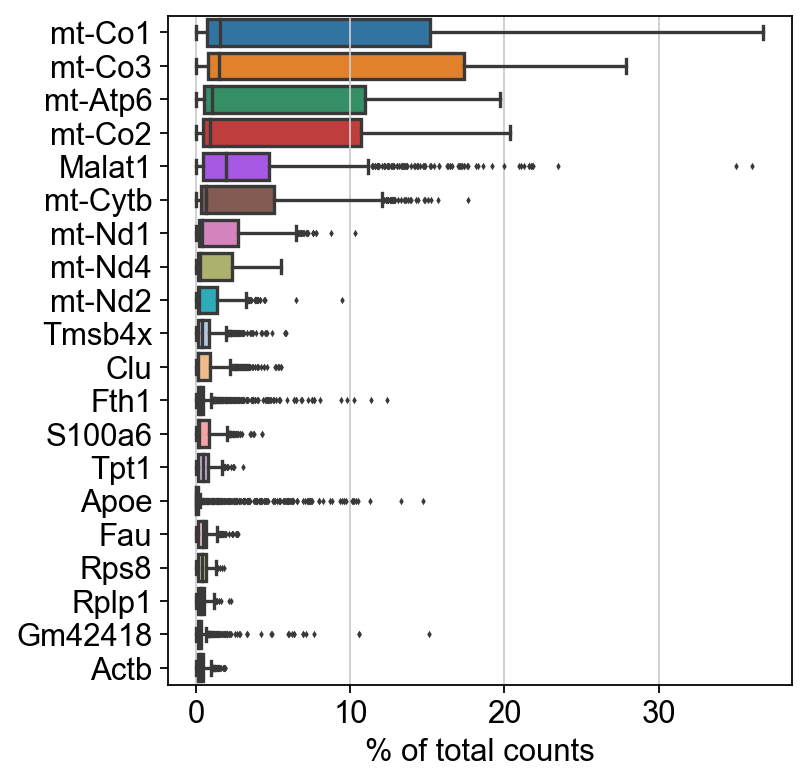

filtered out 379 cells that have less than 200 genes expressed
filtered out 15785 genes that are detected in less than 3 cells

After filter:

AnnData object with n_obs × n_vars = 1368 × 16500
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


In [13]:
path = 'data/Mix1/G12C_1/sample_filtered_feature_bc_matrix/'
adata = read_data(path)

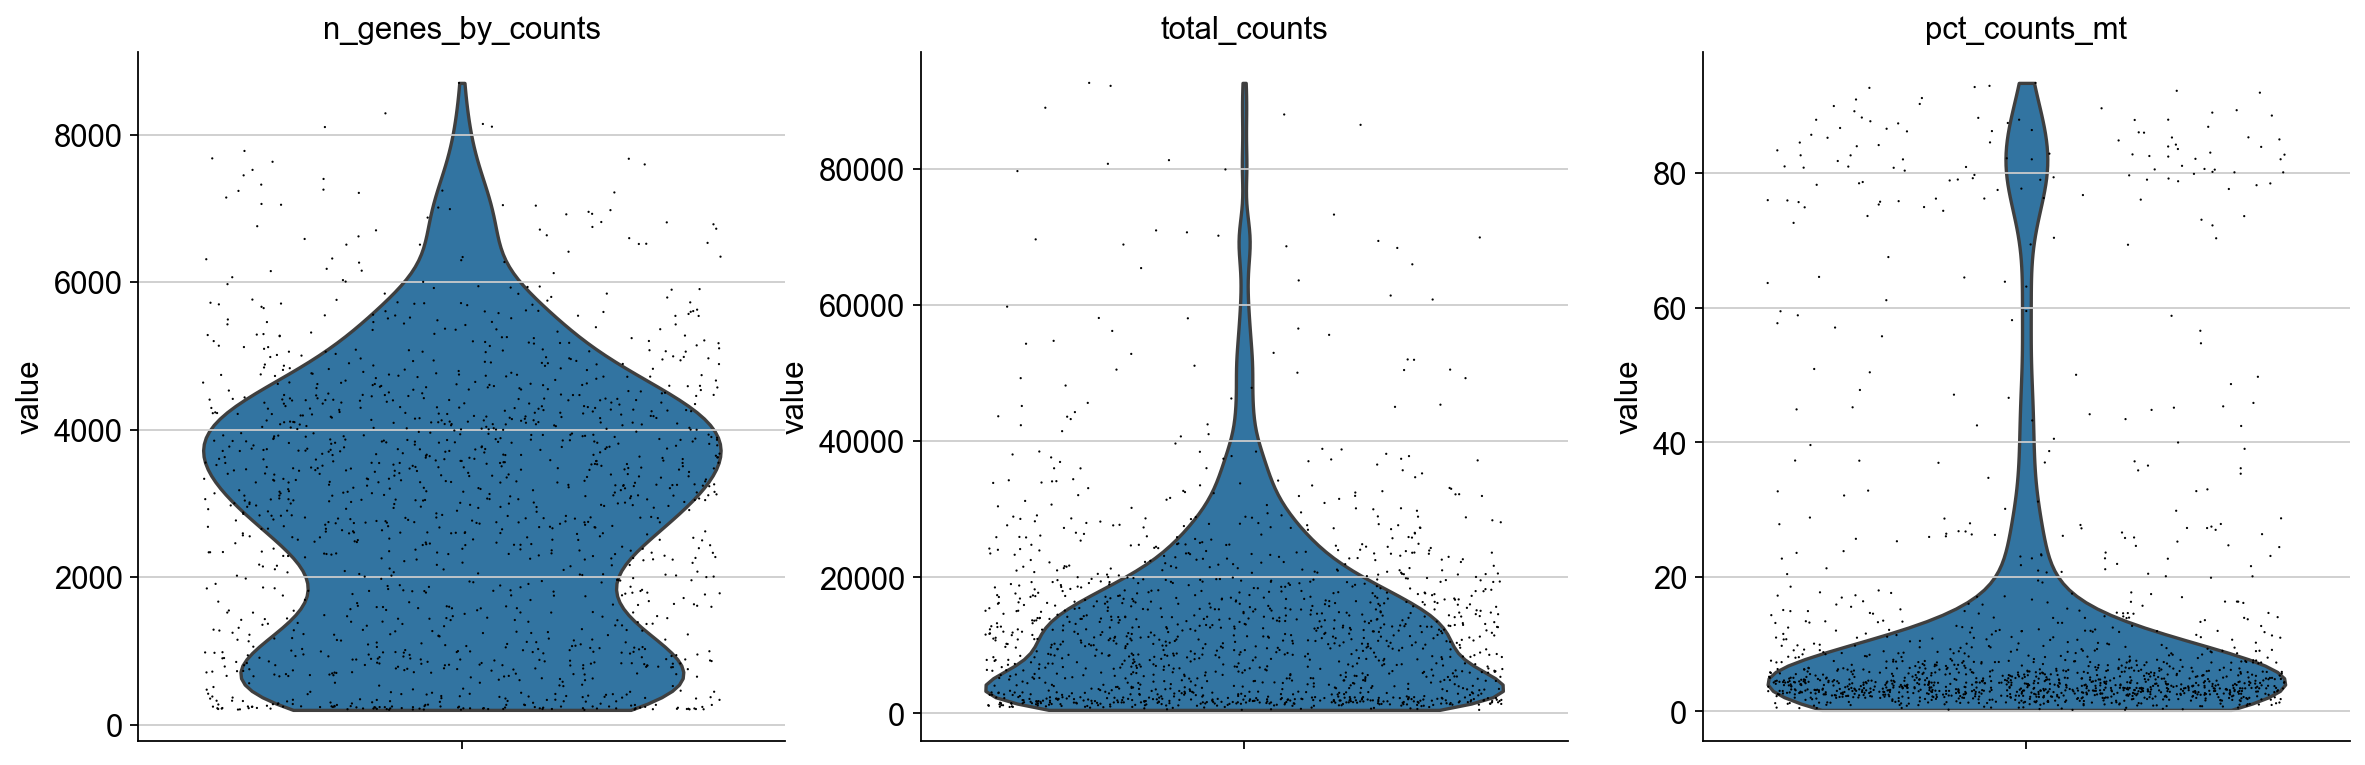

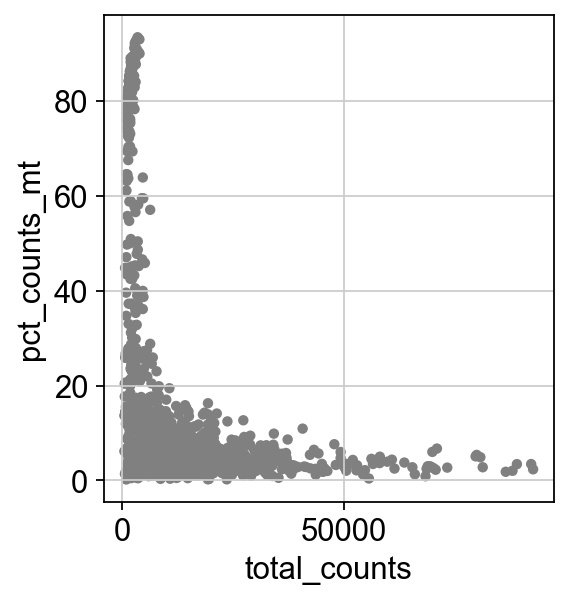

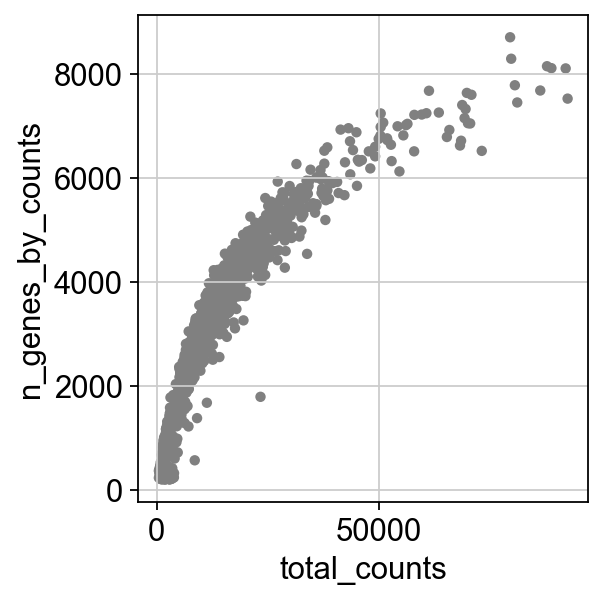

In [15]:
adata = mt_initial_preprocess_and_plot(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


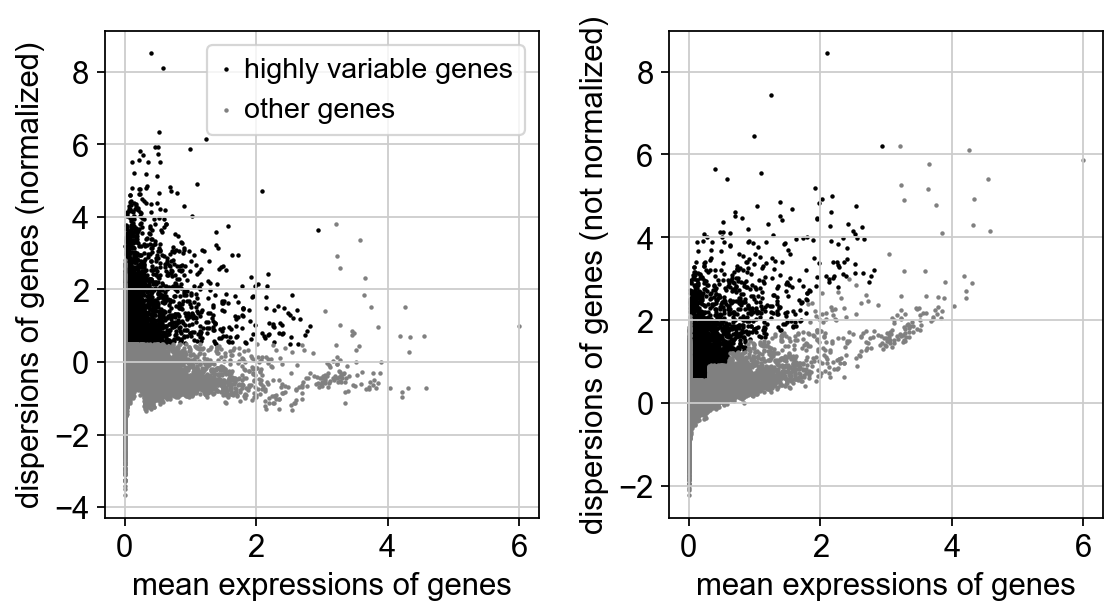

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


In [16]:
adata = preprocess(adata)

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [21]:
sc.pl.pca(adata, color='Sgk3')


AttributeError: 'ColormapRegistry' object has no attribute 'get_cmap'